In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LarsCV, RidgeCV, Lars
import warnings
import random

import datetime
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import catboost as cb
import scipy
from sklearn.cluster import DBSCAN
from pandas.api.types import is_numeric_dtype


from keras import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
np.random.seed(1)
random.seed(1)
import time
import gc

Using TensorFlow backend.


In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8,4)
rcParams['font.size'] = 12

In [3]:
DEBUG = False
REF_DATE = datetime.datetime.strptime('2018-12-31', '%Y-%m-%d')

In [4]:
def skip_func(i, p=0.1, debug=DEBUG):
    if debug == True:
        return (i>0 and random.random()>p)
    else:
        return False

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def print_null(df):
    for col in df:
        if df[col].isnull().any():
            print('%s has %.0f null values: %.3f%%'%(col, df[col].isnull().sum(), df[col].isnull().sum()/df[col].count()*100))

In [7]:
def impute_na(X_train, df, variable):
    # make temporary df copy
    temp = df.copy()
    
    # extract random from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(), random_state=0, replace=True)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(), variable] = random_sample
    return temp[variable]

In [8]:
# Clipping outliers
def clipping_outliers(X_train, df, var):
    IQR = X_train[var].quantile(0.75)-X_train[var].quantile(0.25)
    lower_bound = X_train[var].quantile(0.25) - 6*IQR
    upper_bound = X_train[var].quantile(0.75) + 6*IQR
    no_outliers = len(df[df[var]>upper_bound]) + len(df[df[var]<lower_bound])
    print('There are %i outliers in %s: %.3f%%' %(no_outliers, var, no_outliers/len(df)))
    df[var] = df[var].clip(lower_bound, upper_bound)
    return df

In [9]:
# Discretize continuous variable
def tree_binariser(X_train, X_test, var):
    score_ls = []

    for tree_depth in [1,2,3,4]:
        # call the model
        tree_model = DecisionTreeRegressor(max_depth=tree_depth)

        # train the model using 3 fold cross validation
        scores = cross_val_score(tree_model, X_train[var].to_frame(), X_train['target'], cv=5, scoring='neg_mean_squared_error')
        score_ls.append(np.mean(scores))

    # find depth with smallest mse
    depth = [1,2,3,4][np.argmax(score_ls)]
    #print(score_ls, np.argmax(score_ls), depth)

    # transform the variable using the tree
    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train[var].to_frame(), X_train['target'])
    X_train[var] = tree_model.predict(X_train[var].to_frame())
    #X_val[var] = tree_model.predict(X_val[var].to_frame())
    X_test[var] = tree_model.predict(X_test[var].to_frame())
    return X_train, X_test

<a id='modeling'></a>

## Modeling

Here we use [out of fold stacking ensemble](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/). The architecture is as followed:

**Layer 1**:
* 2 lightgbm
* 1 xgboost
* 1 catboost
* 1 dense neural network

**Layer 2**:
* Lasso regression
* Ridge regression


In [10]:
%%time
train = pd.read_csv('low_features3.csv')
test = pd.read_csv('test_clean3.csv')
#without_outliers
'''train = train[train['outliers'] == 0]]'''
target = train['target']

Wall time: 4.37 s


In [11]:
FEATS_EXCLUDED = [
    'first_active_month', 'target', 'card_id', 'outliers',
    'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
    'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
    'OOF_PRED', 'month_0',
    'new_month_lag_min','quarter','new_month_lag_max','hist_month_lag_max','new_month_diff_var'#40
    'hist_hour_nunique','new_installments_sum','hist_installments_max','new_subsector_id_nunique',
    'new_installments_max','hist_month_lag_min','new_weekofyear_nunique','new_weekend_mean','new_hour_nunique'#30
    'hist_subsector_id_nunique']
features = [c for c in train.columns if c not in FEATS_EXCLUDED]


In [12]:
'''train = train.reset_index(drop=True)
train = train.drop(columns=['target'])'''

#if DEBUG == False:
    #del df_train, df_test
    #gc.collect



"train = train.reset_index(drop=True)\ntrain = train.drop(columns=['target'])"

### First layer
#### Tree-based model

In [13]:
# List of model to use
if DEBUG == True:
    ITERATIONS = 1
else:
    ITERATIONS = 20000
lgb1 = lgb.LGBMRegressor(
                        objective= 'regression_l2',
                        num_leaves=111,
                        max_depth=9,
                        learning_rate=0.0035591640406098355,
                        n_estimators=ITERATIONS,
                        min_child_samples=63,
                        subsample=0.6815424617328696,
                        subsample_freq=1,
                        feature_fraction=0.5020039195436962,
                        reg_lambda=8.570580601734264,
                        random_state=2779,
                        n_jobs=4,
                        metrics='rmse',
                          device = 'gpu',
                          gpu_platform_id= 1,
                          gpu_device_id=0,
                          num_thread = 1,
                          sparse_threshold= 1)

lgb2 = lgb.LGBMRegressor(
                       device= 'gpu',
            gpu_platform_id= 1,
            gpu_device_id= 0,
            objective= 'regression_l2', 
            boosting_type= 'gbdt', 
            n_jobs= 4, max_depth= 7, 
            n_estimators= ITERATIONS, 
            subsample_freq= 2, 
            subsample_for_bin= 200000, 
            min_data_per_group= 100, 
            max_cat_to_onehot= 4, 
            cat_l2= 10.0, 
            cat_smooth= 10.0, 
            max_cat_threshold= 32, 
            metric_freq= 10, 
            verbosity= -1, 
            metric= 'rmse', 
            colsample_bytree= 0.5, 
            learning_rate= 0.0061033234451294376, 
            min_child_samples= 80, 
            min_child_weight= 100.0, 
            min_split_gain= 1e-06, 
            num_leaves= 47, 
            reg_alpha= 10.0, 
            reg_lambda= 10.0, 
            subsample= 0.9)

xgb1 = xgb.XGBRegressor(learning_rate= 0.5843131085630997,
                        booster= 'gbtree',
                        alpha = 1.0239095745311145e-08,
                        boosting= 'gbdt',
                        num_leaves= 31,
                        colsample_bytree= 0.5406862297709868,
                        subsample= 0.9594952525792275,
                        max_depth= 5,
                        reg_lambda= 3.143121436123109,
                        eta= 2.9162386740282797e-07,
                        gamma= 6.015464829655147e-07,
                        grow_policy= 'depthwise',
                       random_state=2018,
                        )

cb1 = cb.CatBoostRegressor(iterations=ITERATIONS, learning_rate=0.005, loss_function='RMSE', bootstrap_type='Bernoulli', depth=9, rsm=0.75, subsample=0.75, random_seed=2019, reg_lambda=1)



In [14]:
if DEBUG==True:
    N_FOLDS=2
else:
    N_FOLDS=11
layer1_models = [lgb1,  cb1,xgb1 ]#, ada1]
layer1_names = ['lightgbm1', 'catboost1','xgboost']#, 'adaboost1']


In [15]:
oof_train = np.zeros(shape=(len(train),len(layer1_models)))
oof_test = np.zeros(shape=(len(test),len(layer1_models)))

# Recording results
layer1_score = []
feature_importance = []

In [17]:
for i in range(len(layer1_models)):
    feature_importance_df = pd.DataFrame()
    print('\n')
    name = layer1_names[i]
    model = layer1_models[i]
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=2019+i)
    print('Training %s' %name)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[features], train['outliers'])):
        print('Fold no %i/%i'%(fold_+1,N_FOLDS))
        trn_data = train[features].iloc[trn_idx]
        trn_label = train['target'].iloc[trn_idx]
        val_data = train[features].iloc[val_idx]
        val_label = train['target'].iloc[val_idx]
        if 'ada' in name:
            model.fit(X=trn_data, y=trn_label)
        else:
            model.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=200,
                     early_stopping_rounds=200)

        oof_train[val_idx,i] = model.predict(val_data)
        oof_test[:,i] += model.predict(test[features])/N_FOLDS
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score = mean_squared_error(oof_train[:,i], target)**0.5
    layer1_score.append(score)
    feature_importance.append(feature_importance_df)
    print('Training CV score: %.5f' %score)



Training lightgbm1
Fold no 1/11
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.69122	valid_1's rmse: 3.73963
[400]	training's rmse: 3.61159	valid_1's rmse: 3.68902
[600]	training's rmse: 3.56074	valid_1's rmse: 3.6677
[800]	training's rmse: 3.52292	valid_1's rmse: 3.6568
[1000]	training's rmse: 3.49334	valid_1's rmse: 3.65166
[1200]	training's rmse: 3.46782	valid_1's rmse: 3.6477
[1400]	training's rmse: 3.44558	valid_1's rmse: 3.64569
[1600]	training's rmse: 3.42506	valid_1's rmse: 3.64403
[1800]	training's rmse: 3.40565	valid_1's rmse: 3.64306
[2000]	training's rmse: 3.38668	valid_1's rmse: 3.64266
[2200]	training's rmse: 3.36965	valid_1's rmse: 3.64246
[2400]	training's rmse: 3.35239	valid_1's rmse: 3.64166
[2600]	training's rmse: 3.33584	valid_1's rmse: 3.64171
[2800]	training's rmse: 3.31946	valid_1's rmse: 3.64194
Early stopping, best iteration is:
[2699]	training's rmse: 3.32751	valid_1's rmse: 3.64153
Fold no 2/11
Training until validat

Fold no 11/11
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.69183	valid_1's rmse: 3.7238
[400]	training's rmse: 3.61168	valid_1's rmse: 3.67923
[600]	training's rmse: 3.56116	valid_1's rmse: 3.66034
[800]	training's rmse: 3.52369	valid_1's rmse: 3.65155
[1000]	training's rmse: 3.49413	valid_1's rmse: 3.64727
[1200]	training's rmse: 3.46857	valid_1's rmse: 3.64485
[1400]	training's rmse: 3.44569	valid_1's rmse: 3.64338
[1600]	training's rmse: 3.42499	valid_1's rmse: 3.64241
[1800]	training's rmse: 3.4056	valid_1's rmse: 3.64157
[2000]	training's rmse: 3.38729	valid_1's rmse: 3.64138
Early stopping, best iteration is:
[1960]	training's rmse: 3.39095	valid_1's rmse: 3.6412
Training CV score: 3.64877


Training catboost1
Fold no 1/11
0:	learn: 3.8683327	test: 3.8683327	test1: 3.8756430	best: 3.8756430 (0)	total: 130ms	remaining: 43m 19s
200:	learn: 3.6985592	test: 3.6985592	test1: 3.7319542	best: 3.7319542 (200)	total: 17.3s	remaining: 28m 21s
400:

4000:	learn: 3.3113002	test: 3.3113002	test1: 3.6212153	best: 3.6211764 (3947)	total: 5m 58s	remaining: 23m 54s
4200:	learn: 3.2960452	test: 3.2960452	test1: 3.6210786	best: 3.6209660 (4180)	total: 6m 16s	remaining: 23m 36s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3.620965992
bestIteration = 4180

Shrink model to first 4181 iterations.
Fold no 4/11
0:	learn: 3.8686235	test: 3.8686235	test1: 3.8733507	best: 3.8733507 (0)	total: 82.7ms	remaining: 27m 33s
200:	learn: 3.6963700	test: 3.6963700	test1: 3.7310561	best: 3.7310561 (200)	total: 18.6s	remaining: 30m 27s
400:	learn: 3.6386565	test: 3.6386565	test1: 3.6983044	best: 3.6983044 (400)	total: 35.9s	remaining: 29m 16s
600:	learn: 3.6045996	test: 3.6045996	test1: 3.6865734	best: 3.6865625 (599)	total: 54s	remaining: 29m 2s
800:	learn: 3.5789929	test: 3.5789929	test1: 3.6800033	best: 3.6799777 (799)	total: 1m 11s	remaining: 28m 32s
1000:	learn: 3.5575707	test: 3.5575707	test1: 3.6753262	best: 3.6753262 (1000)	tota

1200:	learn: 3.5357527	test: 3.5357527	test1: 3.6861612	best: 3.6861184 (1191)	total: 1m 39s	remaining: 26m 4s
1400:	learn: 3.5172071	test: 3.5172071	test1: 3.6845172	best: 3.6845172 (1400)	total: 1m 56s	remaining: 25m 41s
1600:	learn: 3.4995774	test: 3.4995774	test1: 3.6838206	best: 3.6838110 (1524)	total: 2m 12s	remaining: 25m 23s
1800:	learn: 3.4829021	test: 3.4829021	test1: 3.6828659	best: 3.6828487 (1797)	total: 2m 28s	remaining: 25m 4s
2000:	learn: 3.4669326	test: 3.4669326	test1: 3.6825085	best: 3.6823409 (1938)	total: 2m 45s	remaining: 24m 45s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3.682340888
bestIteration = 1938

Shrink model to first 1939 iterations.
Fold no 8/11
0:	learn: 3.8698388	test: 3.8698388	test1: 3.8603294	best: 3.8603294 (0)	total: 81.5ms	remaining: 27m 10s
200:	learn: 3.6987557	test: 3.6987557	test1: 3.7191708	best: 3.7191708 (200)	total: 17.4s	remaining: 28m 34s
400:	learn: 3.6404198	test: 3.6404198	test1: 3.6852921	best: 3.6852921 (40

400:	learn: 3.6401132	test: 3.6401132	test1: 3.6922386	best: 3.6922386 (400)	total: 35.1s	remaining: 28m 36s
600:	learn: 3.6069285	test: 3.6069285	test1: 3.6814671	best: 3.6814671 (600)	total: 52.3s	remaining: 28m 8s
800:	learn: 3.5805951	test: 3.5805951	test1: 3.6768462	best: 3.6768462 (800)	total: 1m 9s	remaining: 27m 37s
1000:	learn: 3.5579131	test: 3.5579131	test1: 3.6732711	best: 3.6732711 (1000)	total: 1m 26s	remaining: 27m 13s
1200:	learn: 3.5380310	test: 3.5380310	test1: 3.6717771	best: 3.6717523 (1179)	total: 1m 42s	remaining: 26m 47s
1400:	learn: 3.5186686	test: 3.5186686	test1: 3.6704298	best: 3.6704143 (1383)	total: 1m 59s	remaining: 26m 23s
1600:	learn: 3.5003592	test: 3.5003592	test1: 3.6696865	best: 3.6696243 (1595)	total: 2m 15s	remaining: 26m 1s
1800:	learn: 3.4836509	test: 3.4836509	test1: 3.6690123	best: 3.6689053 (1771)	total: 2m 32s	remaining: 25m 40s
2000:	learn: 3.4669201	test: 3.4669201	test1: 3.6683431	best: 3.6683431 (2000)	total: 2m 49s	remaining: 25m 20s
220

Exchange two models

In [18]:
oof_preds=np.loadtxt('lgb_oof_preds.csv',delimiter=',')
sub_preds=np.loadtxt('lgb_sub_preds.csv',delimiter=',')

score = score = mean_squared_error(target, oof_preds) ** .5
print('Training CV score for LGB: %.5f' %score)
layer1_names.append('LGB')
layer1_score.append(score)

oof_preds = oof_preds[:, np.newaxis]
sub_preds = sub_preds[:, np.newaxis]
oof_train = np.hstack((oof_train, oof_preds))
oof_test = np.hstack((oof_test, sub_preds))

Training CV score for LGB: 3.64666


In [19]:
oof_preds=np.loadtxt('xgb_oof_preds.csv',delimiter=',')
sub_preds=np.loadtxt('xgb_sub_preds.csv',delimiter=',')

score = score = mean_squared_error(target, oof_preds) ** .5
print('Training CV score for XGB: %.5f' %score)
layer1_names.append('XGB')
layer1_score.append(score)

oof_preds = oof_preds[:, np.newaxis]
sub_preds = sub_preds[:, np.newaxis]
oof_train = np.hstack((oof_train, oof_preds))
oof_test = np.hstack((oof_test, sub_preds))

Training CV score for XGB: 3.64800


In [20]:
layer1_names

['lightgbm1', 'catboost1', 'xgboost', 'LGB', 'XGB']

#### Neural network

In [21]:
# Preparation

import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, Imputer
K.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))


oof_train_nn = np.zeros(shape=(len(train),1))
oof_test_nn = np.zeros(shape=(len(test),1))

'''train = train.dropna(axis=1)
train = train.fillna(0)
obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])'''

scaler = StandardScaler()

#清除空缺值和异常值
train[features] = train[features][~train[features].isin([np.nan, np.inf, -np.inf]).any(1)]
train[features] = train[features].fillna(0)
test[features] = test[features][~test[features].isin([np.nan, np.inf, -np.inf]).any(1)]
test[features] = test[features].fillna(0)

scaler.fit(train[features])

X_train = scaler.transform(train.iloc[:][features].values)
X_test = scaler.transform(test.iloc[:][features].values)

X_train = pd.DataFrame(X_train, index=train[features].index, columns=train[features].columns)
X_test = pd.DataFrame(X_test, index=test[features].index, columns=test[features].columns)


if DEBUG == True:
    EPOCHS=1
else:
    EPOCHS=30 

In [22]:
def nn_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_dim = input_shape, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

early_stop = EarlyStopping(patience=5, verbose=True)

In [23]:
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = X_train.iloc[trn_idx][features]
    trn_label = target.iloc[trn_idx]
    val_data = X_train.iloc[val_idx][features]
    val_label = target.iloc[val_idx]
    model = nn_model(trn_data.shape[1])
    hist = model.fit(trn_data,trn_label,
                     validation_data = (val_data, val_label),
                     epochs=EPOCHS, 
                     batch_size=512, 
                     verbose=True, 
                     callbacks=[early_stop])
    oof_train_nn[val_idx,0] = model.predict(val_data)[:,0]
    oof_test_nn[:,0] += model.predict(X_test[features])[:,0]/N_FOLDS

Fold no 1/11
Train on 183560 samples, validate on 18357 samples
Epoch 1/30
183560/183560 [==============================] - 4s 22us/step - loss: 14.5422 - val_loss: 14.9987
Epoch 2/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.9851 - val_loss: 15.1668
Epoch 3/30
183560/183560 [==============================] - 3s 18us/step - loss: 13.8038 - val_loss: 14.2617
Epoch 4/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.7406 - val_loss: 14.0218
Epoch 5/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.6550 - val_loss: 14.1257
Epoch 6/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.5972 - val_loss: 14.2521
Epoch 7/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.5710 - val_loss: 14.1962
Epoch 8/30
183560/183560 [==============================] - 3s 17us/step - loss: 13.5035 - val_loss: 14.2027
Epoch 9/30
183560/183560 [==============================] - 3s 1

183561/183561 [==============================] - 3s 17us/step - loss: 13.7294 - val_loss: 12.9718
Epoch 5/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.6722 - val_loss: 12.9196
Epoch 6/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.6481 - val_loss: 12.9789
Epoch 7/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.5644 - val_loss: 12.9904
Epoch 8/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.5467 - val_loss: 12.8963
Epoch 9/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4750 - val_loss: 12.9047
Epoch 10/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4541 - val_loss: 12.9000
Epoch 11/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4238 - val_loss: 12.9173
Epoch 12/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.3696 - val_loss: 12.9753
Epoch 13/30
183561/183561 [

183561/183561 [==============================] - 3s 18us/step - loss: 13.4955 - val_loss: 12.3069
Epoch 13/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4850 - val_loss: 12.1930
Epoch 14/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4144 - val_loss: 12.3617
Epoch 15/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.4190 - val_loss: 12.1645
Epoch 16/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.3752 - val_loss: 12.0928
Epoch 17/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.3000 - val_loss: 12.1358
Epoch 18/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.3039 - val_loss: 12.1286
Epoch 19/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.2241 - val_loss: 12.2480
Epoch 20/30
183561/183561 [==============================] - 3s 18us/step - loss: 13.2097 - val_loss: 12.4581
Epoch 21/30
183561/183

In [24]:
score_nn = mean_squared_error(oof_train_nn, target)**0.5
print('Training CV score for neural network: %.5f' %score_nn)
layer1_names.append('neural_net')
layer1_score.append(score_nn)

oof_train = np.hstack((oof_train, oof_train_nn))
oof_test = np.hstack((oof_test, oof_test_nn))

Training CV score for neural network: 3.69827


#### Layer 1 summary

In [25]:
# Print first layer result
layer1 = pd.DataFrame()
layer1['models'] = layer1_names
layer1['CV_score'] = layer1_score
layer1

,models,CV_score
0,lightgbm1,3.648773
1,catboost1,3.648872
2,xgboost,3.679188
3,LGB,3.646658
4,XGB,3.647998
5,neural_net,3.698269


Text(0.5,1,'Pair-wise correlation')

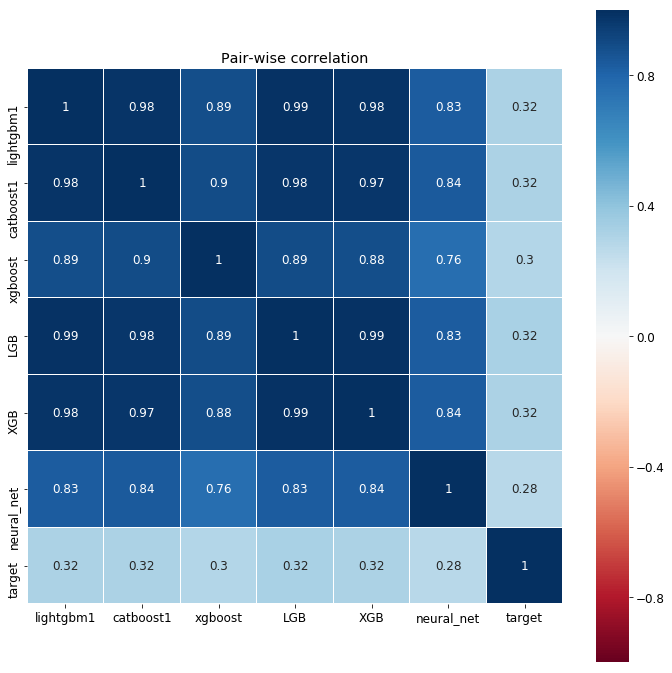

In [26]:
layer1_corr = pd.DataFrame()
for i in range(len(layer1_names)):
    layer1_corr[layer1_names[i]] = oof_train[:,i]
layer1_corr['target'] = target
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
sns.heatmap(layer1_corr.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

### Second layer

In [27]:
# Setup the model
ridge = Ridge(alpha=0.5)#, fit_intercept=False)
lasso = Lasso(alpha=0.5)
lars = Lars(fit_intercept=False, positive=True)
layer2_models = [lars]#[ridge]# lasso]
layer2_names = ['Lars']#['ridge'] #, 'lasso']
#params_grid = {'alpha':[0.05,0.1,0.4,1.0]}

# Setup to record result
train_pred = np.zeros(len(train))
test_pred = np.zeros(len(test))

layer2 = pd.DataFrame()
layer2['models'] = layer2_names
layer2_score = []

In [28]:
# For regression

for i in range(len(layer2_models)):
    print('\n')
    name = layer2_names[i]
    model = layer2_models[i]
    print('Training %s' %name)
    #model, score = do_regressor((oof_train, target), model=model, parameters=params_grid)
    model.fit(oof_train, target)
    score = mean_squared_error(model.predict(oof_train), target)**0.5
    train_pred += model.predict(oof_train)/len(layer2_models)
    test_pred += model.predict(oof_test)/len(layer2_models)
    layer2_score.append(score)
    print('Training score: %.5f' % score)

#layer2['CV score'] = layer2_score
#layer2

layer2_coef = pd.DataFrame()
layer2_coef['Name'] = layer1_names
layer2_coef['Coefficient'] = model.coef_
#layer2_coef['Coefficient'] = coef
layer2_coef



Training Lars
Training score: 3.64381


,Name,Coefficient
0,lightgbm1,0.068676
1,catboost1,0.259549
2,xgboost,0.092281
3,LGB,0.329477
4,XGB,0.227785
5,neural_net,0.080069


In [29]:
'''
# Taking average
train_pred = np.mean(oof_train, axis=1)
test_pred = np.mean(oof_test, axis=1)
print('Training score: %.5f' %mean_squared_error(train_pred, target)**0.5)
'''

"\n# Taking average\ntrain_pred = np.mean(oof_train, axis=1)\ntest_pred = np.mean(oof_test, axis=1)\nprint('Training score: %.5f' %mean_squared_error(train_pred, target)**0.5)\n"

In [30]:
#np.sum(model.coef_)

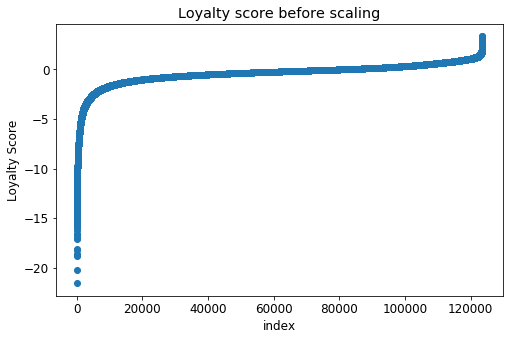

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(test_pred)), np.sort(test_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score before scaling')
plt.show()

In [32]:
# Refit to the target
train_scaler = StandardScaler()
#train_scaler.fit(target.values.reshape(-1,1))
#test_pred = train_scaler.inverse_transform(test_pred.reshape(-1,1))

### Submission

In [33]:
#sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission["target"] = test_pred
sample_submission.to_csv("model-stacking-ensemble-low_features-StratifiedKFold11.csv ", index=False)

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(range(sub_df.shape[0]), np.sort(sub_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Loyalty score after scaling')
plt.show()

NameError: name 'sub_df' is not defined

<Figure size 576x360 with 0 Axes>